# Preparing the dataset

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Flatten, Dense, Input, Lambda, Conv2D, MaxPooling2D, Dropout,BatchNormalization
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.models import Model, Sequential,load_model
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix,roc_curve, auc,accuracy_score
from sklearn.preprocessing import label_binarize

from glob import glob
from PIL import ImageFile


In [2]:
IMAGE_SIZE = [224,224]
train_path = "../input/yoga-poses-dataset/DATASET/TRAIN"
test_path = "../input/yoga-poses-dataset/DATASET/TEST"

In [3]:
resent_model = ResNet50V2(include_top=False, weights='imagenet',
                          input_shape=IMAGE_SIZE + [3])

94674944/94668760 [==============================] - 2s 0us/step


In [4]:
for layer in resent_model.layers:
    layer.trainable = False

In [5]:
x = Conv2D(128, (3, 3), activation='relu')(resent_model.output)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dense(5,activation='softmax')(x)

model = Model(inputs=resent_model.input, outputs=x)


In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [7]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [8]:
class_labels = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']

In [9]:
train_datagen = ImageDataGenerator(rescale=1 / 255.0,
                                   rotation_range = 10, 
                                   zoom_range = 0.20, 
                                   shear_range = 0.20,
                                   fill_mode = "nearest", 
                                   validation_split=0.10,
                       
                                   width_shift_range=0.2,     # Randomly shift images horizontally by 20% of the image width
                                   height_shift_range=0.2,    # Randomly shift images vertically by 20% of the image height

                                   horizontal_flip=True)      # Randomly flip images horizontall )

test_datagen = ImageDataGenerator(
    rescale = 1./255,
)



In [10]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

batch_size = 8
training_set = train_datagen.flow_from_directory(
        directory=train_path, 
        color_mode="rgb",
        target_size=(224, 224), 
        batch_size=batch_size,
        class_mode='sparse',  
        subset='training',
        shuffle=True,
        seed=42)

# this is a similar generator, for validation data
validation_set = train_datagen.flow_from_directory(
        directory=train_path,
        color_mode="rgb",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='sparse',
        subset='validation',
        shuffle=True,
        seed=42)

testing_set = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    seed=42)

Found 974 images belonging to 5 classes.
Found 107 images belonging to 5 classes.
Found 470 images belonging to 5 classes.


In [11]:
# ImageFile.LOAD_TRUNCATED_IMAGES = True

lrr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001)

In [12]:
hist = model.fit(training_set,
                validation_data = validation_set,
                epochs = 10,
                steps_per_epoch=len(training_set),
                validation_steps=len(validation_set),
                callbacks=[lrr]
                )


Train for 122 steps, validate for 14 steps
Epoch 1/10
 36/122 [=======>......................] - ETA: 1:37 - loss: 2.3287 - accuracy: 0.3750

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


122/122 [==============================] - 139s 1s/step - loss: 1.5954 - accuracy: 0.4877 - val_loss: 1.5435 - val_accuracy: 0.6355
Epoch 2/10
122/122 [==============================] - 133s 1s/step - loss: 0.9426 - accuracy: 0.6561 - val_loss: 0.9499 - val_accuracy: 0.7103
Epoch 3/10
122/122 [==============================] - 135s 1s/step - loss: 0.8602 - accuracy: 0.7156 - val_loss: 1.3972 - val_accuracy: 0.7103
Epoch 4/10
122/122 [==============================] - 135s 1s/step - loss: 0.7192 - accuracy: 0.7495 - val_loss: 1.2692 - val_accuracy: 0.6822
Epoch 5/10
122/122 [==============================] - 132s 1s/step - loss: 0.5997 - accuracy: 0.7834 - val_loss: 0.6964 - val_accuracy: 0.8318
Epoch 6/10
122/122 [==============================] - 132s 1s/step - loss: 0.6181 - accuracy: 0.7988 - val_loss: 0.9925 - val_accuracy: 0.7944
Epoch 7/10
122/122 [==============================] - 134s 1s/step - loss: 0.4776 - accuracy: 0.8378 - val_loss: 1.1712 - val_accuracy: 0.8037
Epoch 8/10

In [13]:
predictions = model.predict(testing_set)
prediction_probs = predictions
# Get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

true_labels = testing_set.classes

/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag))


In [14]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Accuracy on the testing set: {accuracy:.2f}")

Accuracy on the testing set: 0.89


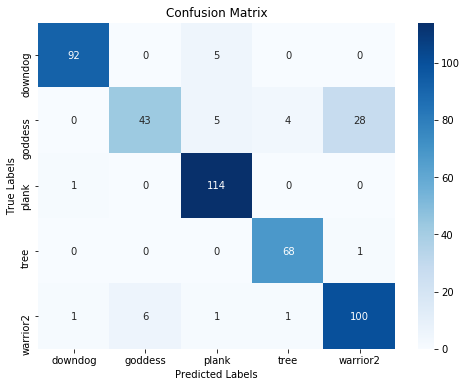

In [15]:

cm = confusion_matrix(true_labels, predicted_labels)
# Create a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# confusion matrix
plot_confusion_matrix(cm, class_labels)


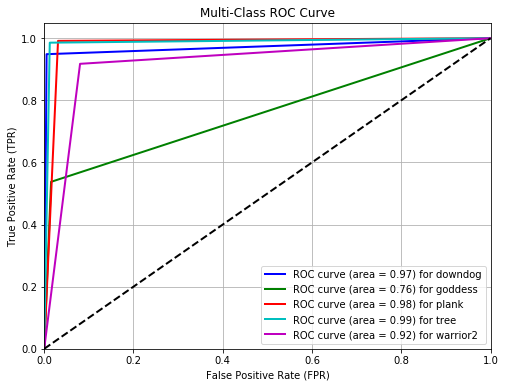

In [16]:
# Binarize the true labels for multi-class ROC
n_classes = len(np.unique(true_labels))
true_labels_bin = label_binarize(true_labels, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], (predicted_labels == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c', 'm']  
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve (area = {:.2f}) for {}'.format(roc_auc[i], class_labels[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [17]:
model.save('model.h5')